### Install and import required dependencies

In [ ]:
!pip install -qqq featuretools

In [ ]:
import featuretools as ft
import pandas as pd
from google.colab import drive
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/Data Mining and Warehousing')
data = pd.read_excel('Superstore_SAS_TRAIN.xlsx')
data.head()

,OrderDate,OrderDate_DAY,OrderDate_MONTH,OrderDate_YEAR,ShipDate,ShipDate_DAY,ShipDate_MONTH,ShipDate_YEAR,ShipMode,CustomerID,...,PostalCode,ProductID,Category,SubCategory,ProductName,Sales,Quantity,Profit,IMP_Region,IMP_Discount
0,2018-10-07,7,10,2018,2018-10-11,11,10,2018,Second Class,MA-17560,...,77036,OFF-PA-10000249,Office Supplies,Paper,Easy-staple paper,29.4720,3,9.9468,Central,0.20
1,2017-12-03,3,12,2017,2017-12-07,7,12,2017,Standard Class,SN-20710,...,77036,FUR-BO-10002545,Furniture,Bookcases,Atlantic Metals Mobile 3-Shelf Bookcases,532.3992,3,-46.9764,Central,0.32
2,2017-06-05,5,6,2017,2017-06-06,6,6,2017,First Class,TB-21055,...,45373,TEC-AC-10002167,Technology,Accessories,ImationḊ8gb Micro Traveldrive Usb 2.0ḊFlash Drive,30.0000,2,3.3000,East,0.00
3,2017-06-05,5,6,2017,2017-06-06,6,6,2017,First Class,TB-21055,...,45373,OFF-AR-10001868,Office Supplies,Art,Prang Dustless Chalk Sticks,1.6800,1,0.8400,East,0.00
4,2017-04-06,6,4,2017,2015-05-05,5,5,2015,Standard Class,PS-18970,...,60653,FUR-CH-10001146,Furniture,Chairs,Global Task Chair,213.1150,5,-15.2225,Central,0.30


In [ ]:
data.columns

Index(['OrderDate', 'OrderDate_DAY', 'OrderDate_MONTH', 'OrderDate_YEAR',
       'ShipDate', 'ShipDate_DAY', 'ShipDate_MONTH', 'ShipDate_YEAR',
       'ShipMode', 'CustomerID', 'CustomerName', 'Segment', 'City', 'State',
       'PostalCode', 'ProductID', 'Category', 'SubCategory', 'ProductName',
       'Sales', 'Quantity', 'Profit', 'IMP_Region', 'IMP_Discount'],
      dtype='object')

## Featuretools: Create entities and relationships

In [ ]:
# Convert OrderDate and ShipDate to datetime if not already
data['OrderDate'] = pd.to_datetime(data['OrderDate'])
data['ShipDate'] = pd.to_datetime(data['ShipDate'])

# Prepare the OrderDate dimension table
order_date_table = data[['OrderDate']].drop_duplicates().reset_index(drop=True)
order_date_table['OrderDateID'] = order_date_table.index + 1

# Prepare the ShipDate dimension table
ship_date_table = data[['ShipDate']].drop_duplicates().reset_index(drop=True)
ship_date_table['ShipDateID'] = ship_date_table.index + 1

# Prepare the Shipping dimension table
shipping_table = data[['ShipMode']].drop_duplicates().reset_index(drop=True)
shipping_table['ShippingID'] = shipping_table.index + 1

# Map OrderDateID and ShipDateID to transactions
data = data.merge(order_date_table[['OrderDate', 'OrderDateID']], on='OrderDate', how='left')
data = data.merge(ship_date_table[['ShipDate', 'ShipDateID']], on='ShipDate', how='left')
data = data.merge(shipping_table[['ShipMode', 'ShippingID']], on='ShipMode', how='left')


In [ ]:
data.columns

Index(['OrderDate', 'OrderDate_DAY', 'OrderDate_MONTH', 'OrderDate_YEAR',
       'ShipDate', 'ShipDate_DAY', 'ShipDate_MONTH', 'ShipDate_YEAR',
       'ShipMode', 'CustomerID', 'CustomerName', 'Segment', 'City', 'State',
       'PostalCode', 'ProductID', 'Category', 'SubCategory', 'ProductName',
       'Sales', 'Quantity', 'Profit', 'IMP_Region', 'IMP_Discount',
       'OrderDateID', 'ShipDateID', 'ShippingID'],
      dtype='object')

In [ ]:
# Drop useless columns
data.drop(["CustomerName", "ProductName"], axis=1, inplace=True)
data.columns

Index(['OrderDate', 'OrderDate_DAY', 'OrderDate_MONTH', 'OrderDate_YEAR',
       'ShipDate', 'ShipDate_DAY', 'ShipDate_MONTH', 'ShipDate_YEAR',
       'ShipMode', 'CustomerID', 'Segment', 'City', 'State', 'PostalCode',
       'ProductID', 'Category', 'SubCategory', 'Sales', 'Quantity', 'Profit',
       'IMP_Region', 'IMP_Discount', 'OrderDateID', 'ShipDateID',
       'ShippingID'],
      dtype='object')

In [ ]:
# Create an EntitySet
es = ft.EntitySet(id='Superstore')

# Add the Transactions dataframe
data['TransactionID'] = range(1, len(data) + 1)
es.add_dataframe(dataframe_name='transactions',
                 dataframe=data,
                 index='TransactionID')

# Add OrderDate dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                 new_dataframe_name='order_dates',
                 index='OrderDateID',
                 additional_columns=['OrderDate', 'OrderDate_YEAR', 'OrderDate_MONTH', 'OrderDate_DAY'])

# Add ShipDate dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                 new_dataframe_name='ship_dates',
                 index='ShipDateID',
                 additional_columns=['ShipDate','ShipDate_YEAR', 'ShipDate_MONTH', 'ShipDate_DAY'])

# Add Customer dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='customers',
                       index='CustomerID',
                       additional_columns=['Segment'])

# Add Product dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='products',
                       index='ProductID',
                       additional_columns=['Category', 'SubCategory'])


# Add Geography dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='geography',
                       index='PostalCode',
                       additional_columns=['City', 'State', 'IMP_Region'])

# Add Shipping dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='shipping',
                       index='ShippingID',
                       additional_columns=['ShipMode'])

es

Entityset: Superstore
  DataFrames:
    transactions [Rows: 900, Columns: 11]
    order_dates [Rows: 480, Columns: 5]
    ship_dates [Rows: 478, Columns: 5]
    customers [Rows: 494, Columns: 2]
    products [Rows: 702, Columns: 3]
    geography [Rows: 255, Columns: 4]
    shipping [Rows: 4, Columns: 2]
  Relationships:
    transactions.OrderDateID -> order_dates.OrderDateID
    transactions.ShipDateID -> ship_dates.ShipDateID
    transactions.CustomerID -> customers.CustomerID
    transactions.ProductID -> products.ProductID
    transactions.PostalCode -> geography.PostalCode
    transactions.ShippingID -> shipping.ShippingID

In [ ]:
print(es["transactions"].columns)
print(es["order_dates"].columns)
print(es["ship_dates"].columns)
print(es["customers"].columns)
print(es["products"].columns)
print(es["geography"].columns)
print(es["shipping"].columns)

Index(['CustomerID', 'PostalCode', 'ProductID', 'Sales', 'Quantity', 'Profit',
       'IMP_Discount', 'OrderDateID', 'ShipDateID', 'ShippingID',
       'TransactionID'],
      dtype='object')
Index(['OrderDateID', 'OrderDate', 'OrderDate_YEAR', 'OrderDate_MONTH',
       'OrderDate_DAY'],
      dtype='object')
Index(['ShipDateID', 'ShipDate', 'ShipDate_YEAR', 'ShipDate_MONTH',
       'ShipDate_DAY'],
      dtype='object')
Index(['CustomerID', 'Segment'], dtype='object')
Index(['ProductID', 'Category', 'SubCategory'], dtype='object')
Index(['PostalCode', 'City', 'State', 'IMP_Region'], dtype='object')
Index(['ShippingID', 'ShipMode'], dtype='object')


In [ ]:
feature_matrix, feature_defs = ft.dfs(entityset=es, \
                                      target_dataframe_name='transactions', \
                                      max_depth=2, \
                                      verbose=1, \
                                      n_jobs=8,
                                      ignore_columns={'transactions': ['Sales']})

Built 141 features
Elapsed: 00:00 | Progress:   0%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/utils.py:160: UserWarning: 8 workers requested, but only 2 workers created.
  warnings.warn(warning_string)
INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37631
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33501'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38891'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33093', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33093
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60352
INFO:distributed.scheduler:Register worker <WorkerSt

EntitySet scattered to 2 workers in 3 seconds
Elapsed: 00:01 | Progress:  48%|████▊     

INFO:distributed.scheduler:Remove client Client-e5372a6a-adcc-11ee-935a-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:60382; closing.
INFO:distributed.scheduler:Remove client Client-e5372a6a-adcc-11ee-935a-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-e5372a6a-adcc-11ee-935a-0242ac1c000c
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:33501'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:38891'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:60352; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:33093', name: 0, status: closing, memory: 1, processing: 0> (stimulus_id='handle-worker-cleanup-1704680607.5408342')
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0

Elapsed: 00:03 | Progress: 100%|██████████


In [ ]:
print(f'Generated {len(feature_defs)} features')
for feature in feature_defs:
  print(feature)

Generated 141 features
<Feature: PostalCode>
<Feature: Quantity>
<Feature: Profit>
<Feature: IMP_Discount>
<Feature: OrderDateID>
<Feature: ShipDateID>
<Feature: ShippingID>
<Feature: order_dates.OrderDate_YEAR>
<Feature: order_dates.OrderDate_MONTH>
<Feature: order_dates.OrderDate_DAY>
<Feature: ship_dates.ShipDate_YEAR>
<Feature: ship_dates.ShipDate_MONTH>
<Feature: ship_dates.ShipDate_DAY>
<Feature: customers.Segment>
<Feature: products.Category>
<Feature: products.SubCategory>
<Feature: geography.State>
<Feature: geography.IMP_Region>
<Feature: shipping.ShipMode>
<Feature: order_dates.COUNT(transactions)>
<Feature: order_dates.MAX(transactions.IMP_Discount)>
<Feature: order_dates.MAX(transactions.Profit)>
<Feature: order_dates.MAX(transactions.Quantity)>
<Feature: order_dates.MEAN(transactions.IMP_Discount)>
<Feature: order_dates.MEAN(transactions.Profit)>
<Feature: order_dates.MEAN(transactions.Quantity)>
<Feature: order_dates.MIN(transactions.IMP_Discount)>
<Feature: order_dates.

In [ ]:
# Correlation Analysis
# Correlation with Target Variable
feature_matrix = feature_matrix.merge(data['Sales'], left_index=True, right_index=True)
correlation_with_target = feature_matrix.corr().abs()['Sales'].sort_values()

# Multicollinearity Check: Correlation Matrix
correlation_matrix = feature_matrix.corr()

<ipython-input-14-5223381201a7>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_target = feature_matrix.corr().abs()['Sales'].sort_values()
<ipython-input-14-5223381201a7>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = feature_matrix.corr()


<ipython-input-15-4953856462f9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_with_sales = feature_matrix.corr().abs()['Sales'].sort_values(ascending=False)


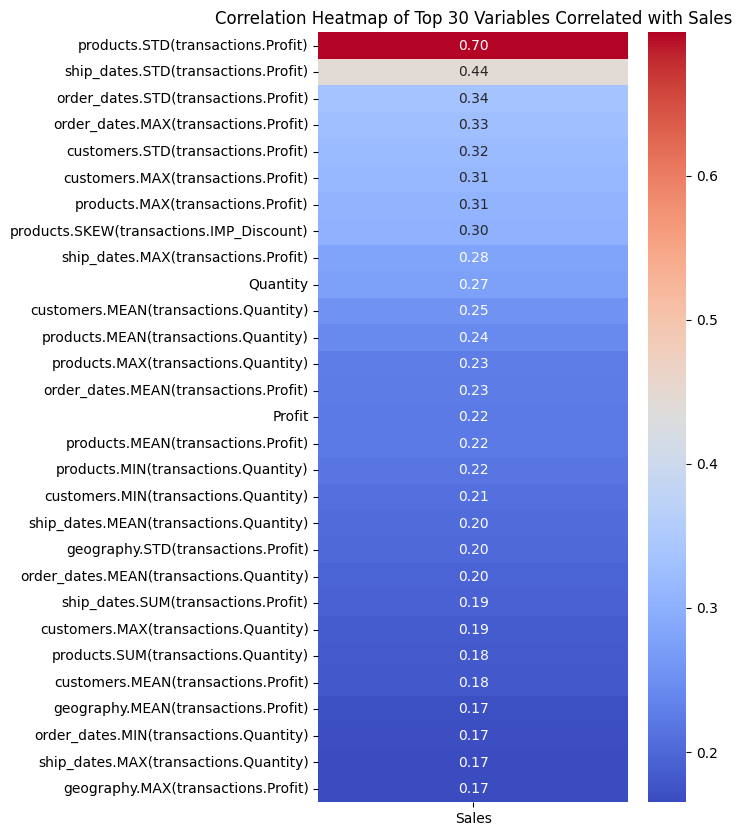

In [ ]:
correlation_with_sales = feature_matrix.corr().abs()['Sales'].sort_values(ascending=False)

# Get the top 30 variables most correlated with 'Sales', excluding 'Sales' itself
top_30_features = correlation_with_sales.head(30).index.tolist()

top_30_features.remove('Sales')  # Remove 'Sales' from the list

# Create a DataFrame that shows only the correlation of each feature with 'Sales'
sales_corr = pd.DataFrame(correlation_with_sales).loc[top_30_features]

# Plot the correlation heatmap
plt.figure(figsize=(5, 10))
sns.heatmap(sales_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top 30 Variables Correlated with Sales')
plt.show()

## Feature selections

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.linear_model import LassoCV
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [ ]:
# Step 1: Filter Methods
# Correlation Analysis
correlation_matrix = feature_matrix.corr()
# Selecting features that have a high correlation with the target
target = 'Sales'  # replace with your actual target variable name

# Prepare data
features_high_corr_with_target_NAN_impute0 = [col for col in correlation_matrix[target].index[correlation_matrix[target].abs() > 0.2] if col != target]
# Identify STD columns from the selected features
NAN_columns_in_high_corr = [col for col in features_high_corr_with_target_NAN_impute0 if 'STD' in col or 'SKEW' in col]
# Fill NaN values in these STD columns with 0 in the feature_matrix
feature_matrix[NAN_columns_in_high_corr] = feature_matrix[NAN_columns_in_high_corr].fillna(0)

features_high_corr_with_target_noNANcol = [col for col in features_high_corr_with_target_NAN_impute0 if 'STD' not in col or 'SKEW' not in col]

experiment_set = [
    (features_high_corr_with_target_noNANcol, 'abs corr coe > 0.5, no STD'),
    (features_high_corr_with_target_NAN_impute0, 'abs corr coe > 0.5, STD NAN imputed 0')]

# features_high_corr_with_target_STD_impute0
# feature_matrix['products.SKEW(transactions.IMP_Discount)']

<ipython-input-17-2ef395a49c8d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = feature_matrix.corr()


In [ ]:
result_set = {}

for features_high_corr_with_target, title in experiment_set:
  # Step 2: Model-Based Selection
  # Using RandomForest for feature importance
  rf = RandomForestRegressor(random_state=42)
  rf.fit(feature_matrix[features_high_corr_with_target], feature_matrix[target])
  importances = rf.feature_importances_
  # Selecting features based on importance
  sfm = SelectFromModel(rf, threshold='median')
  sfm.fit(feature_matrix[features_high_corr_with_target], feature_matrix[target])
  selected_features_sfm = feature_matrix[features_high_corr_with_target].columns[sfm.get_support()]

  # Step 3: Wrapper Method
  # Recursive Feature Elimination
  rfe = RFECV(rf, step=1, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=42), scoring='neg_mean_squared_error')
  rfe.fit(feature_matrix[selected_features_sfm], feature_matrix[target])
  selected_features_rfe = selected_features_sfm[rfe.support_]

  # Final Selected Features
  final_selected_features = list(selected_features_rfe)
  result_set[title] = final_selected_features

result_set

{'abs corr coe > 0.5, no STD': ['Profit',
  'order_dates.MAX(transactions.Profit)',
  'order_dates.MEAN(transactions.Profit)',
  'order_dates.STD(transactions.Profit)',
  'ship_dates.MAX(transactions.Profit)',
  'customers.MAX(transactions.Profit)',
  'customers.MEAN(transactions.Quantity)',
  'products.MAX(transactions.Profit)',
  'products.MEAN(transactions.Profit)',
  'products.STD(transactions.Profit)'],
 'abs corr coe > 0.5, STD NAN imputed 0': ['Profit',
  'order_dates.MAX(transactions.Profit)',
  'order_dates.MEAN(transactions.Profit)',
  'order_dates.STD(transactions.Profit)',
  'ship_dates.MAX(transactions.Profit)',
  'customers.MAX(transactions.Profit)',
  'customers.MEAN(transactions.Quantity)',
  'products.MAX(transactions.Profit)',
  'products.MEAN(transactions.Profit)',
  'products.STD(transactions.Profit)']}

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(max_iter=10000, alpha=1.0, random_state=42))
    ]),
    "Lasso Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(max_iter=10000, alpha=1.0, random_state=42))
    ]),
    "Elastic Net": Pipeline([
        ('scaler', StandardScaler()),
        ('model', ElasticNet(max_iter=10000, alpha=1.0, l1_ratio=0.5, random_state=42))
    ]),
    "Decision Tree Regressor": DecisionTreeRegressor(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ),
    "Gradient Boosting Regressor": GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    ),
    "Support Vector Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(C=1.0, kernel='rbf', gamma='scale'))  # SVR does not use random_state
    ]),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )
}

# Iterate through each feature set and model
for key in result_set.keys():
    features = result_set[key]
    print(f"Feature set: {key}")
    for model_name, model in models.items():
        print(f"   Evaluating Model: {model_name}")
        scores = cross_val_score(model, feature_matrix[features], feature_matrix[target], cv=5, scoring='neg_mean_squared_error')
        mean_score = -sum(scores)/len(scores)  # Negate the score for MSE
        # print("      Cross-Validation Scores:", scores)
        print("      Mean Cross-Validation MSE:", mean_score)
    print()
    # break

## Works best on Random Forest Regressor and Gradient Boosting Regressor

Feature set: abs corr coe > 0.5, no STD
   Evaluating Model: Linear Regression
      Mean Cross-Validation MSE: 201214.65298313886
   Evaluating Model: Ridge Regression
      Mean Cross-Validation MSE: 201557.77112417965
   Evaluating Model: Lasso Regression
      Mean Cross-Validation MSE: 203511.96934893858
   Evaluating Model: Elastic Net
      Mean Cross-Validation MSE: 195596.7683113707
   Evaluating Model: Decision Tree Regressor
      Mean Cross-Validation MSE: 157678.38135805508
   Evaluating Model: Gradient Boosting Regressor
      Mean Cross-Validation MSE: 94512.0129577069
   Evaluating Model: Support Vector Regression
      Mean Cross-Validation MSE: 253491.2503037961
   Evaluating Model: Random Forest Regressor
      Mean Cross-Validation MSE: 99072.63778359382

Feature set: abs corr coe > 0.5, STD NAN imputed 0
   Evaluating Model: Linear Regression
      Mean Cross-Validation MSE: 201214.65298313886
   Evaluating Model: Ridge Regression
      Mean Cross-Validation MSE: 2

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def calculate_adjusted_r_squared(r_squared, n, p):
    return 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))

def calculate_ccc(y_true, y_pred):
    """
    Calculate the Concordance Correlation Coefficient (CCC) between two arrays.

    :param y_true: Array of observed values.
    :param y_pred: Array of predicted values.
    :return: Concordance Correlation Coefficient.
    """
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)

    covariance = np.mean((y_pred - mean_pred) * (y_true - mean_true))
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)

    correlation = (2 * covariance) / (var_pred + var_true + (mean_pred - mean_true) ** 2)
    return correlation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for key in result_set.keys():
    features = result_set[key]
    print(f"Feature set: {key}")
    for model_name, model in models.items():
        print(f"   Evaluating Model: {model_name}")
        mse_values, r2_values, ccc_values = [], [], []
        for train_index, test_index in kf.split(feature_matrix):
            X_train, X_test = feature_matrix[features].iloc[train_index], feature_matrix[features].iloc[test_index]
            y_train, y_test = feature_matrix[target].iloc[train_index], feature_matrix[target].iloc[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse_values.append(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            r2_values.append(r2)
            ccc_values.append(calculate_ccc(y_test, y_pred))
        mean_mse = np.mean(mse_values)
        mean_r2 = np.mean(r2_values)
        mean_ccc = np.mean(ccc_values)
        adj_r2 = calculate_adjusted_r_squared(mean_r2, len(feature_matrix), len(features))
        print(f"      Mean Cross-Validation MSE: {mean_mse}")
        print(f"      Mean Cross-Validation Adjusted R-Squared: {adj_r2}")
        print(f"      Mean Cross-Validation CCC: {mean_ccc}")
    print()

Feature set: abs corr coe > 0.5, no STD
   Evaluating Model: Linear Regression
      Mean Cross-Validation MSE: 202862.21407563775
      Mean Cross-Validation Adjusted R-Squared: 0.1110419584051463
      Mean Cross-Validation CCC: 0.4368793427786861
   Evaluating Model: Ridge Regression
      Mean Cross-Validation MSE: 203707.82145456565
      Mean Cross-Validation Adjusted R-Squared: 0.10109554058351933
      Mean Cross-Validation CCC: 0.4270558954061291
   Evaluating Model: Lasso Regression
      Mean Cross-Validation MSE: 206885.58235838654
      Mean Cross-Validation Adjusted R-Squared: 0.0831799569123427
      Mean Cross-Validation CCC: 0.4165010557555836
   Evaluating Model: Elastic Net
      Mean Cross-Validation MSE: 195491.53945468058
      Mean Cross-Validation Adjusted R-Squared: 0.13878463054341295
      Mean Cross-Validation CCC: 0.36856048586622125
   Evaluating Model: Decision Tree Regressor
      Mean Cross-Validation MSE: 127552.52984911478
      Mean Cross-Validation 

In [ ]:
# Add to original dataset
final_dataset_with_feature_engineering = pd.merge(data, feature_matrix[result_set['abs corr coe > 0.5, STD NAN imputed 0']], on='TransactionID', how='left')

In [ ]:
final_dataset_with_feature_engineering

,OrderDate,OrderDate_DAY,OrderDate_MONTH,OrderDate_YEAR,ShipDate,ShipDate_DAY,ShipDate_MONTH,ShipDate_YEAR,ShipMode,CustomerID,...,Profit_y,order_dates.MAX(transactions.Profit),order_dates.MEAN(transactions.Profit),order_dates.STD(transactions.Profit),ship_dates.MAX(transactions.Profit),customers.MAX(transactions.Profit),customers.MEAN(transactions.Quantity),products.MAX(transactions.Profit),products.MEAN(transactions.Profit),products.STD(transactions.Profit)
0,2018-10-07,7,10,2018,2018-10-11,11,10,2018,Second Class,MA-17560,...,9.9468,9.9882,-7.355150,32.955870,9.9468,55.7640,3.000000,9.9468,9.94680,0.000000
1,2017-12-03,3,12,2017,2017-12-07,7,12,2017,Standard Class,SN-20710,...,-46.9764,71.9700,20.256680,47.998775,61.3890,14.6510,3.250000,-46.9764,-46.97640,0.000000
2,2017-06-05,5,6,2017,2017-06-06,6,6,2017,First Class,TB-21055,...,3.3000,52.9173,17.072325,24.304574,52.9173,20.9670,1.333333,4.9500,4.12500,1.166726
3,2017-06-05,5,6,2017,2017-06-06,6,6,2017,First Class,TB-21055,...,0.8400,52.9173,17.072325,24.304574,52.9173,20.9670,1.333333,4.2000,2.52000,2.375879
4,2017-04-06,6,4,2017,2015-05-05,5,5,2015,Standard Class,PS-18970,...,-15.2225,49.9704,14.243033,33.044462,-15.2225,76.9816,4.500000,76.1125,14.60826,38.897490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,2016-03-08,8,3,2016,2016-03-11,11,3,2016,First Class,DH-13075,...,353.5792,353.5792,189.231200,232.423171,363.9048,353.5792,8.000000,353.5792,215.88730,194.725752
896,2016-04-07,7,4,2016,2016-04-12,12,4,2016,Standard Class,AS-10240,...,3.6744,374.9925,189.333450,262.561546,3.6744,3.6744,3.000000,3.6744,3.67440,0.000000
897,2015-04-12,12,4,2015,2016-04-05,5,4,2016,Second Class,RD-19660,...,0.4074,0.4074,0.407400,0.000000,0.5460,146.4036,4.000000,0.4074,0.40740,0.000000
898,2014-11-11,11,11,2014,2015-11-05,5,11,2015,Standard Class,KN-16705,...,2.1900,55.7640,28.977000,37.882539,2.1900,11.4296,2.750000,2.1900,1.46000,1.032376


In [ ]:
# Remove redundant columns
final_dataset_with_feature_engineering.drop(["Profit_y"], axis=1, inplace=True)

# Rename column
final_dataset_with_feature_engineering.rename({"Profit_x":"Profit"}, inplace=True)

In [ ]:
# Update fact table
# Convert OrderDate and ShipDate to datetime if not already
data['OrderDate'] = pd.to_datetime(data['OrderDate'])
data['ShipDate'] = pd.to_datetime(data['ShipDate'])

# Prepare the OrderDate dimension table
order_date_table = data[['OrderDate']].drop_duplicates().reset_index(drop=True)
order_date_table['OrderDateID'] = order_date_table.index + 1

# Prepare the ShipDate dimension table
ship_date_table = data[['ShipDate']].drop_duplicates().reset_index(drop=True)
ship_date_table['ShipDateID'] = ship_date_table.index + 1

# Prepare the Shipping dimension table
shipping_table = data[['ShipMode']].drop_duplicates().reset_index(drop=True)
shipping_table['ShippingID'] = shipping_table.index + 1

# Map OrderDateID and ShipDateID to transactions
data = data.merge(order_date_table[['OrderDate', 'OrderDateID']], on='OrderDate', how='left')
data = data.merge(ship_date_table[['ShipDate', 'ShipDateID']], on='ShipDate', how='left')
data = data.merge(shipping_table[['ShipMode', 'ShippingID']], on='ShipMode', how='left')

# Create an EntitySet
es = ft.EntitySet(id='Updated_Superstore')

# Add the Transactions dataframe
data['TransactionID'] = range(1, len(data) + 1)
es.add_dataframe(dataframe_name='transactions',
                 dataframe=final_dataset_with_feature_engineering,
                 index='TransactionID')

# Add OrderDate dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                 new_dataframe_name='order_dates',
                 index='OrderDateID',
                 additional_columns=['OrderDate', 'OrderDate_YEAR', 'OrderDate_MONTH', 'OrderDate_DAY'])

# Add ShipDate dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                 new_dataframe_name='ship_dates',
                 index='ShipDateID',
                 additional_columns=['ShipDate','ShipDate_YEAR', 'ShipDate_MONTH', 'ShipDate_DAY'])

# Add Customer dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='customers',
                       index='CustomerID',
                       additional_columns=['Segment'])

# Add Product dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='products',
                       index='ProductID',
                       additional_columns=['Category', 'SubCategory'])


# Add Geography dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='geography',
                       index='PostalCode',
                       additional_columns=['City', 'State', 'IMP_Region'])

# Add Shipping dimension table
es.normalize_dataframe(base_dataframe_name='transactions',
                       new_dataframe_name='shipping',
                       index='ShippingID',
                       additional_columns=['ShipMode'])

es

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(


Entityset: Updated_Superstore
  DataFrames:
    transactions [Rows: 900, Columns: 20]
    order_dates [Rows: 480, Columns: 5]
    ship_dates [Rows: 478, Columns: 5]
    customers [Rows: 494, Columns: 2]
    products [Rows: 702, Columns: 3]
    geography [Rows: 255, Columns: 4]
    shipping [Rows: 4, Columns: 2]
  Relationships:
    transactions.OrderDateID -> order_dates.OrderDateID
    transactions.ShipDateID -> ship_dates.ShipDateID
    transactions.CustomerID -> customers.CustomerID
    transactions.ProductID -> products.ProductID
    transactions.PostalCode -> geography.PostalCode
    transactions.ShippingID -> shipping.ShippingID

In [ ]:
print(es["transactions"].columns)
print(es["order_dates"].columns)
print(es["ship_dates"].columns)
print(es["customers"].columns)
print(es["products"].columns)
print(es["geography"].columns)
print(es["shipping"].columns)

Index(['CustomerID', 'PostalCode', 'ProductID', 'Sales', 'Quantity',
       'Profit_x', 'IMP_Discount', 'OrderDateID', 'ShipDateID', 'ShippingID',
       'TransactionID', 'order_dates.MAX(transactions.Profit)',
       'order_dates.MEAN(transactions.Profit)',
       'order_dates.STD(transactions.Profit)',
       'ship_dates.MAX(transactions.Profit)',
       'customers.MAX(transactions.Profit)',
       'customers.MEAN(transactions.Quantity)',
       'products.MAX(transactions.Profit)',
       'products.MEAN(transactions.Profit)',
       'products.STD(transactions.Profit)'],
      dtype='object')
Index(['OrderDateID', 'OrderDate', 'OrderDate_YEAR', 'OrderDate_MONTH',
       'OrderDate_DAY'],
      dtype='object')
Index(['ShipDateID', 'ShipDate', 'ShipDate_YEAR', 'ShipDate_MONTH',
       'ShipDate_DAY'],
      dtype='object')
Index(['CustomerID', 'Segment'], dtype='object')
Index(['ProductID', 'Category', 'SubCategory'], dtype='object')
Index(['PostalCode', 'City', 'State', 'IMP_Region'], 

In [ ]:
# Save the final dataframe into csv
from datetime import datetime
final_dataset_with_feature_engineering.to_csv(f'Superstore-with-Featuretools-{datetime.now()}.csv', index=False)